In [64]:
import pandas as pd
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import shapiro, mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE



import json

In [65]:
training_path = "/content/drive/MyDrive/MLR503 Final Exam Preparation/challenge2Data/training.json"
testing_path = "/content/drive/MyDrive/MLR503 Final Exam Preparation/challenge2Data/test.json"
ground_truth_testing_path = "/content/drive/MyDrive/MLR503 Final Exam Preparation/challenge2Data/ground_truth.json"

In [66]:
with open(training_path, "r") as file:
    training_data = [json.loads(line) for line in file.readlines()[1:]]

training_df = pd.DataFrame(training_data)

print(training_df.columns)
print(training_df.head())
print(training_df.shape)

Index(['Physics', 'Chemistry', 'PhysicalEducation', 'English', 'Mathematics',
       'serial', 'Biology', 'Accountancy', 'BusinessStudies', 'Economics',
       'ComputerScience'],
      dtype='object')
   Physics  Chemistry  PhysicalEducation  English  Mathematics  serial  \
0      8.0        7.0                3.0        4            6  195490   
1      1.0        1.0                1.0        3            3  190869   
2      1.0        2.0                2.0        1            2    3111   
3      8.0        7.0                6.0        7            7   47738   
4      1.0        1.0                1.0        3            2   85520   

   Biology  Accountancy  BusinessStudies  Economics  ComputerScience  
0      NaN          NaN              NaN        NaN              NaN  
1      NaN          NaN              NaN        NaN              NaN  
2      NaN          NaN              NaN        NaN              NaN  
3      NaN          NaN              NaN        NaN              NaN 

In [67]:
training_df = training_df.drop(columns=["serial"])

In [68]:
print(training_df.columns)
print(training_df.head())

Index(['Physics', 'Chemistry', 'PhysicalEducation', 'English', 'Mathematics',
       'Biology', 'Accountancy', 'BusinessStudies', 'Economics',
       'ComputerScience'],
      dtype='object')
   Physics  Chemistry  PhysicalEducation  English  Mathematics  Biology  \
0      8.0        7.0                3.0        4            6      NaN   
1      1.0        1.0                1.0        3            3      NaN   
2      1.0        2.0                2.0        1            2      NaN   
3      8.0        7.0                6.0        7            7      NaN   
4      1.0        1.0                1.0        3            2      NaN   

   Accountancy  BusinessStudies  Economics  ComputerScience  
0          NaN              NaN        NaN              NaN  
1          NaN              NaN        NaN              NaN  
2          NaN              NaN        NaN              NaN  
3          NaN              NaN        NaN              NaN  
4          NaN              NaN        NaN     

In [69]:
nan_counts = training_df.isna().sum()

print(nan_counts)

Physics              13715
Chemistry            13648
PhysicalEducation    47062
English                  0
Mathematics              0
Biology              64612
Accountancy          65904
BusinessStudies      66006
Economics            65433
ComputerScience      60945
dtype: int64


In [70]:
required_subject_combinations = [
    {"Physics", "Chemistry", "ComputerScience"},
    {"Physics", "Chemistry", "PhysicalEducation"},
    {"Physics", "Chemistry", "Economics"},
    {"Physics", "Chemistry", "Biology"},
    {"Economics", "Accountancy", "BusinessStudies"}
]


def matches_refined_combination(row, combinations):
    non_null_subjects = {col for col in row.index if not pd.isnull(row[col]) and col != "English"}
    for combination in combinations:
        if combination.issubset(non_null_subjects):
            return True
    return False

filtered_training_df = training_df[
    training_df.apply(lambda row: matches_refined_combination(row, required_subject_combinations), axis=1)
]


print(filtered_training_df.shape)


(78580, 10)


In [71]:
nan_counts = filtered_training_df.isna().sum()

print(nan_counts)

Physics              12928
Chemistry            12928
PhysicalEducation    46997
English                  0
Mathematics              0
Biology              63816
Accountancy          65652
BusinessStudies      65652
Economics            64674
ComputerScience      60253
dtype: int64


In [72]:
filtered_training_df = filtered_training_df.drop(columns=["Accountancy", "BusinessStudies", "Economics", "Biology"])

In [73]:
feature_statistics = filtered_training_df.describe().loc[['mean', '50%']].T.rename(columns={'50%': 'median'})

In [74]:
stats = filtered_training_df.describe().T
stats['median'] = filtered_training_df.median()
stats

,count,mean,std,min,25%,50%,75%,max,median
Physics,65652.0,3.988515,2.210990,1.0,2.0,4.0,6.0,8.0,4.0
Chemistry,65652.0,3.976482,2.161482,1.0,2.0,4.0,6.0,8.0,4.0
PhysicalEducation,31583.0,3.160276,1.896878,1.0,2.0,3.0,4.0,8.0,3.0
English,78580.0,3.053932,1.786821,1.0,1.0,3.0,4.0,8.0,3.0
Mathematics,78580.0,4.225643,2.350898,1.0,2.0,4.0,6.0,8.0,4.0
ComputerScience,18327.0,3.847329,2.134831,1.0,2.0,4.0,6.0,8.0,4.0


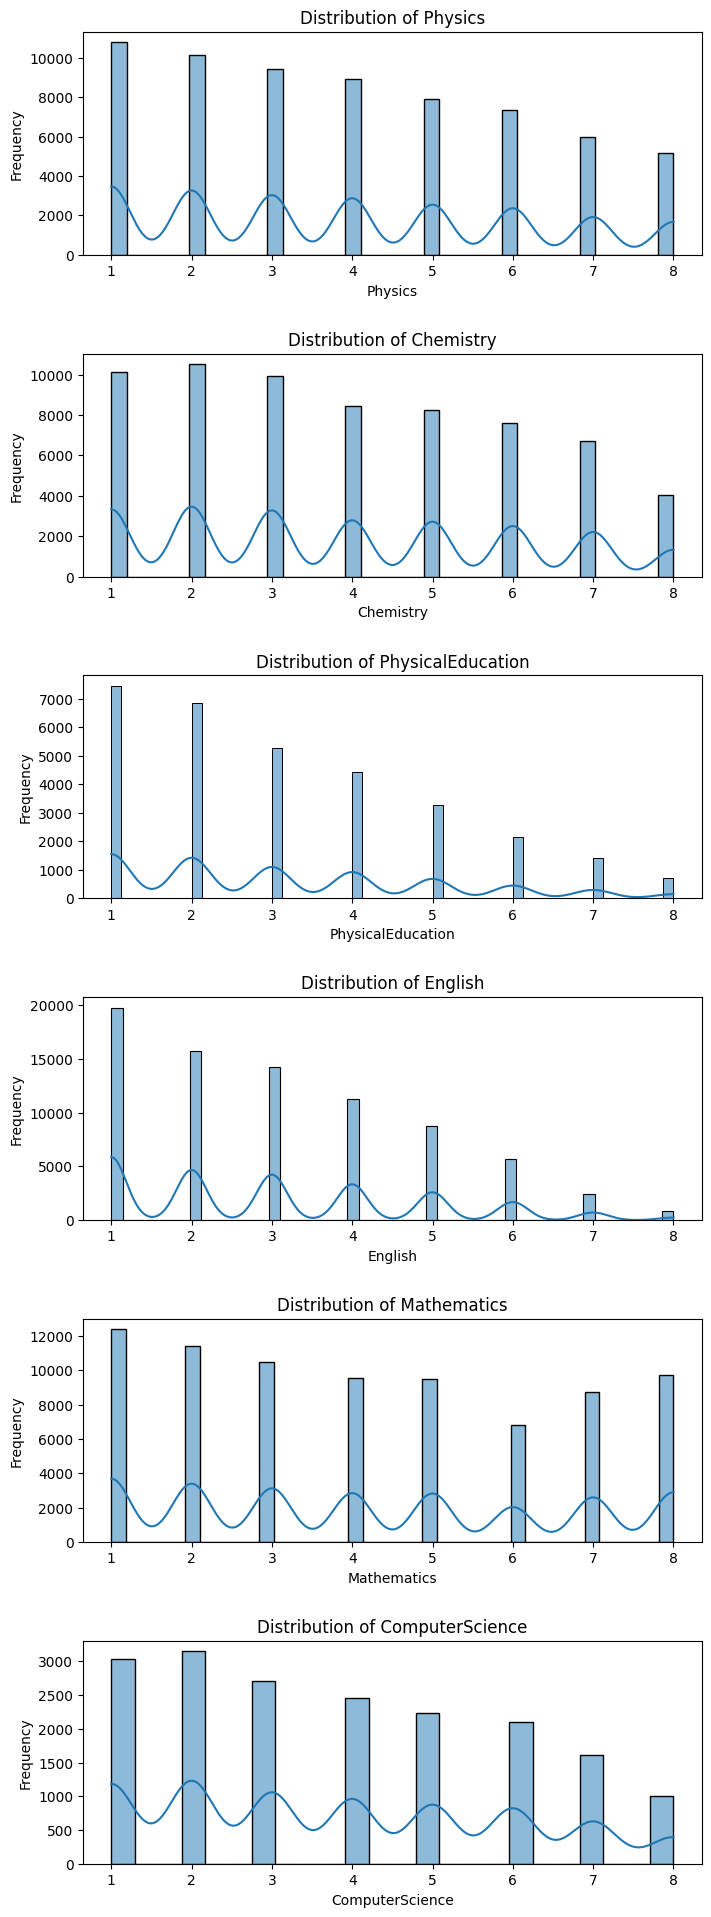

In [75]:
fig, axes = plt.subplots(nrows=filtered_training_df.shape[1], ncols=1, figsize=(8, 20))
fig.tight_layout(pad=5.0)

for i, column in enumerate(filtered_training_df.columns):
    sns.histplot(filtered_training_df[column], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")

plt.show()

The mean and the median are relatively close to each other. We will look at the filtered dataset one last time:

In [76]:
nan_counts = filtered_training_df.isna().sum()

print(nan_counts)

Physics              12928
Chemistry            12928
PhysicalEducation    46997
English                  0
Mathematics              0
ComputerScience      60253
dtype: int64


In [77]:
physics_median = filtered_training_df["Physics"].median()
chemistry_median = filtered_training_df["Chemistry"].median()
filtered_training_df["Physics"].fillna(physics_median, inplace=True)
filtered_training_df["Chemistry"].fillna(chemistry_median, inplace=True)

<ipython-input-77-95c3c01b7ae2>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_training_df["Physics"].fillna(physics_median, inplace=True)
<ipython-input-77-95c3c01b7ae2>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [78]:
nan_counts = filtered_training_df.isna().sum()

print(nan_counts)

Physics                  0
Chemistry                0
PhysicalEducation    46997
English                  0
Mathematics              0
ComputerScience      60253
dtype: int64


In [79]:
filtered_training_df = filtered_training_df.dropna(thresh=int(0.5 * filtered_training_df.shape[1]))

In [80]:
filtered_training_df.shape

(78580, 6)

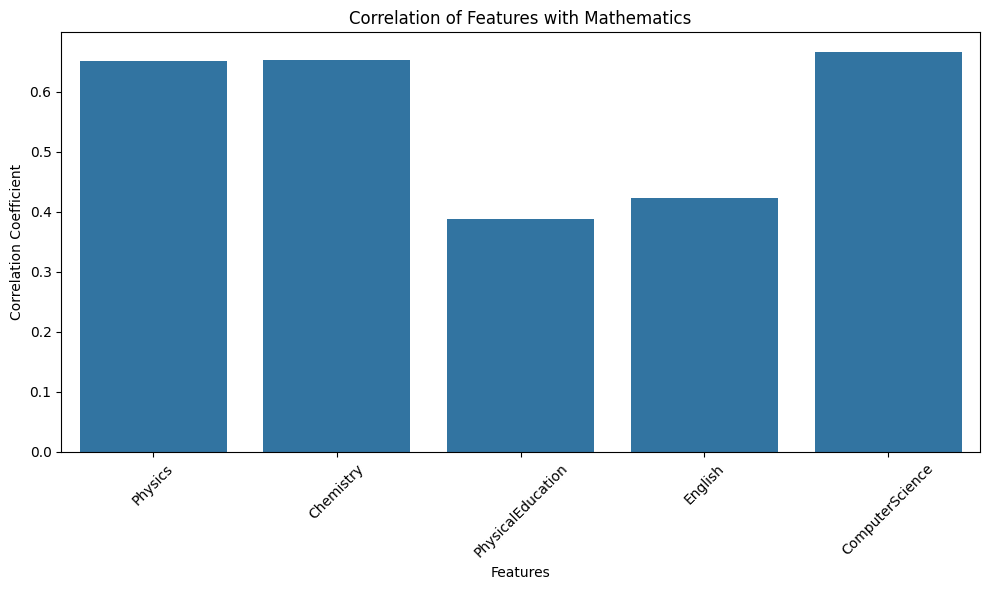

In [82]:
correlation_matrix = filtered_training_df.corr()

# Extract correlations with 'Mathematics'
math_correlations = correlation_matrix["Mathematics"].drop("Mathematics")

# Plot the correlations as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=math_correlations.index, y=math_correlations.values)
plt.title("Correlation of Features with Mathematics")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Low correlation with Physical Education, so we can just drop it. But for Computer Science, the correlation is pretty high. So I think we should keep it.

In [83]:
filtered_training_df = filtered_training_df.drop(columns=["PhysicalEducation"])

Running models and stuff is actually pretty easy to do here, so I won't bother. The performance is pretty bad though.